---
execute:
  cache: false
  eval: true
  echo: true
  warning: false
jupyter: python3
---

# Pytorch Lightning: Hyperparameter Tuning with Diabetes Data


In [1]:
#| echo: false
#| label: 100_imports
import numpy as np
import os
from math import inf
import numpy as np
import warnings
if not os.path.exists('./figures'):
    os.makedirs('./figures')
warnings.filterwarnings("ignore")

In this tutorial, we will show how `spotPython` can be integrated into the `PyTorch` Lightning
training workflow for a regression task.

## The Diabetes Data Set {#sec-the-diabetes-data-set-100}

This chapter describes the hyperparameter tuning of a `PyTorch Lightning` network on the Diabetes data set. This is a PyTorch Dataset for regression. A toy data set from scikit-learn. Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients,  as well as the response of interest, a quantitative measure of disease progression one year after baseline.


### Data Exploration of the sklearn Diabetes Data Set

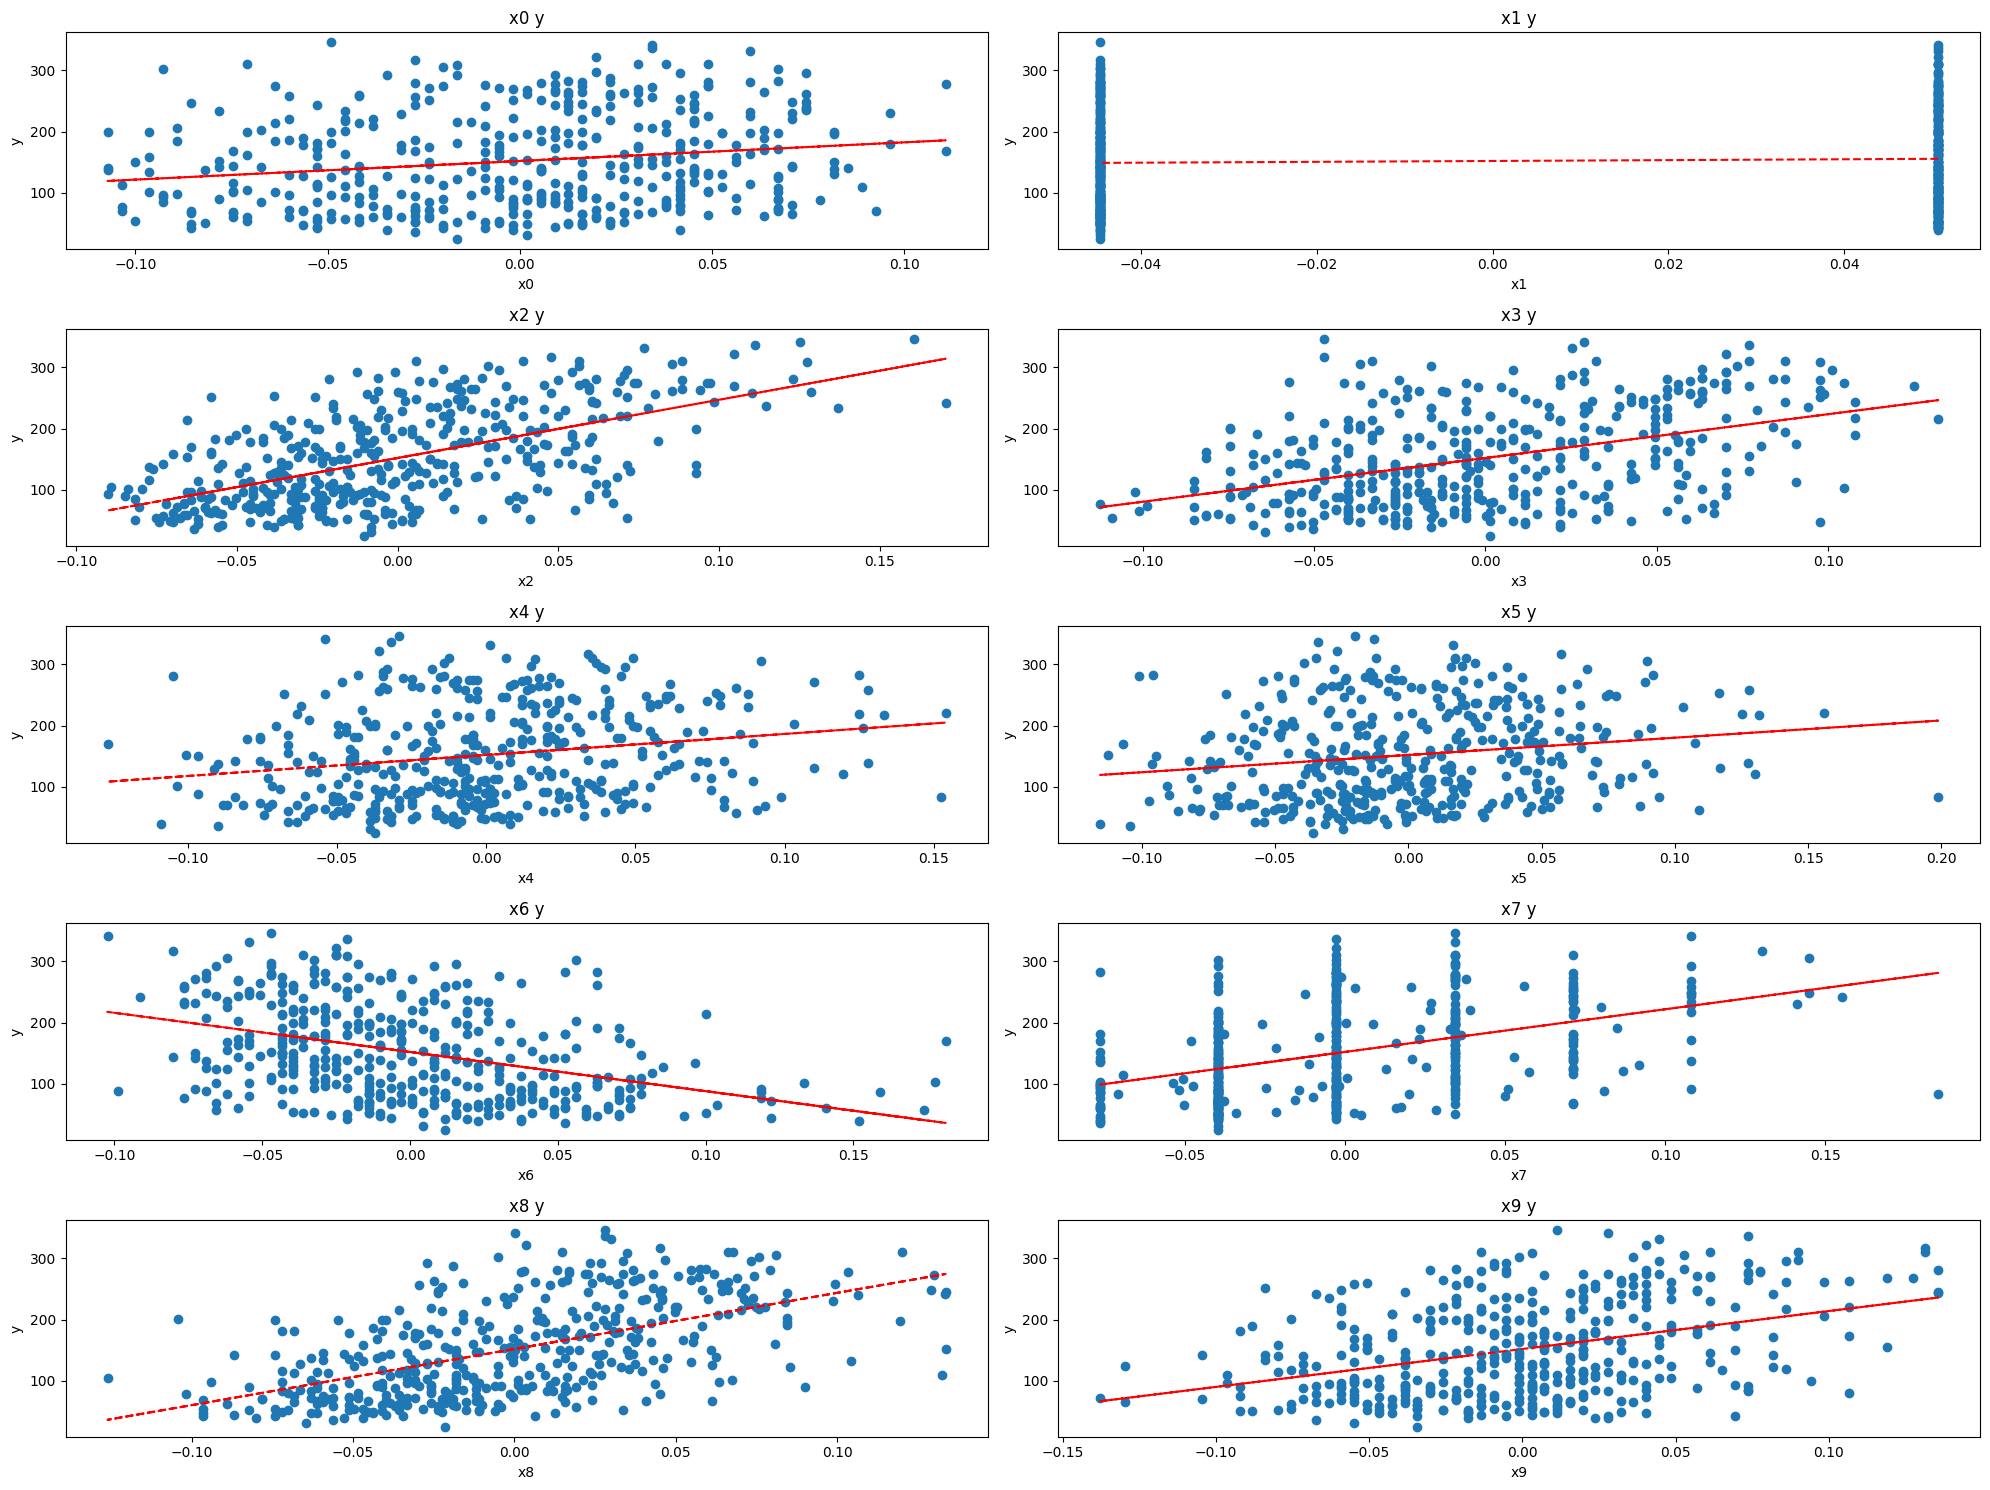

In [2]:
from sklearn.datasets import load_diabetes
from spotPython.plot.xy import plot_y_vs_X
data = load_diabetes()
X, y = data.data, data.target
plot_y_vs_X(X, y, nrows=5, ncols=2, figsize=(20, 15))


* Each of these 10 feature variables have been mean centered and scaled by the standard deviation times the square root of n_samples (i.e. the sum of squares of each column totals 1).

* HDL (high-density lipoprotein) cholesterol, sometimes called “good” cholesterol, absorbs cholesterol in the blood and carries it back to the liver.
* The liver then flushes it from the body.
* High levels of HDL cholesterol can lower your risk for heart disease and stroke.


### Generating the PyTorch data set


In [3]:
from spotPython.data.diabetes import Diabetes
data_set = Diabetes()
print(len(data_set))
print(data_set.names)

442
['age', 'sex', 'bmi', 'bp', 's1_tc', 's2_ldl', 's3_hdl', 's4_tch', 's5_ltg', 's6_glu']


## Setup{#sec-setup-24}

### General Experiment Setup{#sec-general-experiment-setup-24}

To keep track of the different experiments, we use a `PREFIX` for the experiment name. The `PREFIX` is used to create a unique experiment name. The `PREFIX` is also used to create a unique TensorBoard folder, which is used to store the TensorBoard log files.

`spotpython` allows the specification of two different types of stopping criteria: first, the number of function evaluations (`fun_evals`), and second, the maximum run time in seconds (`max_time`). Here, we will set the number of function evaluations to infinity and the maximum run time to one minute.

Furthermore, we set the initial design size (`init_size`) to 10. The initial design is used to train the surrogate model. The surrogate model is used to predict the performance of the hyperparameter configurations. The initial design is also used to train the first model. Since the `init_size` belongs to the experimental design, it is set in the `design_control` dictionary, see [[SOURCE]](https://sequential-parameter-optimization.github.io/spotPython/reference/spotPython/utils/init/#spotPython.utils.init.design_control_init).

`max_time` is set to one minute for demonstration purposes and `init_size` is set to 10 for demonstration purposes. For real experiments, these values should be increased.
Note,  the total run time may exceed the specified `max_time`, because the initial design is always evaluated, even if this takes longer than `max_time`.

The following parameters are used to specify the general experiment setup:

In [4]:
#| label: 024_sum_exp
PREFIX = "100"
fun_evals = inf
max_time = 1
init_size = 10

### Data Preprocessing {#sec-preprocessing-100}

Preprocessing is handled by `Lightning` and `PyTorch`. It is described in the [LIGHTNINGDATAMODULE](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) documentation. Here you can find information about the `transforms` methods.


###  Data Splitting

The data splitting is handled by `Lightning`.

### Loss Function {#sec-loss-function-100}

The loss function is specified in the configurable network class [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/light/regression/netlightregression.py)
We will use MSE.

### Metric {#sec-metric-31}

* Similar to the loss function, the metric is specified in the configurable network class [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/light/regression/netlightregression.py).

* The loss function and the metric are not hyperparameters that can be tuned with `spotPython`.
* They are handled by `Lightning`.

### The Objective Function `fun` {#sec-the-objective-function-31}

The objective function `fun` from the class `HyperLight` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/fun/hyperlight.py) is selected next. It implements an interface from `PyTorch`'s training, validation, and testing methods to `spotPython`.

In [5]:
from spotPython.fun.hyperlight import HyperLight
fun = HyperLight().fun

### Model Setup

By using `core_model_name = "light.regression.NetLightRegression"`, the `spotPython` model class `NetLightRegression` [[SOURCE]](https://sequential-parameter-optimization.github.io/spotPython/reference/spotPython/light/regression/netlightregression/) from the `light.regression` module is selected.
For a given `core_model_name`, the corresponding hyperparameters are automatically loaded from the associated dictionary, which is stored as a JSON file. The JSON file contains hyperparameter type information, names, and bounds. For `spotPython` models, the hyperparameters are stored in the `LightHyperDict`, see [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/hyperdict/light_hyper_dict.json)
Alternatively, you can load a local hyper_dict.
The `hyperdict`  uses the default hyperparameter settings. These can be modified as described in @sec-modifying-hyperparameter-levels.

The following parameters are used for the model setup:

In [6]:
#| label: 100_sum_model-setup
from spotPython.hyperdict.light_hyper_dict import LightHyperDict
core_model_name = "light.regression.NetLightRegression"
hyperdict = LightHyperDict
_L_in=10
_L_out=1

### Surrogate Model Setup

The default surrogate model is the `Kriging` model, see [[SOURCE]](https://sequential-parameter-optimization.github.io/spotPython/reference/spotPython/build/kriging/). We specify `noise` as `True` to include noise in the model. An `anisotropic` kernel is used, which allows different length scales for each dimension, by setting `n_theta = 2`. Furthermore, the interval for the `Lambda` value is set to `[1e-3, 1e2]`.

These parameters are set in the `surrogate_control` dictionary and therefore passed  to the `surrogate_control_init` function [[SOURCE]](https://sequential-parameter-optimization.github.io/spotPython/reference/spotPython/utils/init/#spotPython.utils.init.surrogate_control_init).

In [7]:
#| label: 100_surrogate_control_setup
noise = True
n_theta = 2
min_Lambda = 1e-3
max_Lambda = 10

### Summary: Setting up the Experiment {#sec-summary-setting-up-the-experiment-24}

At this stage, all required information is available to set up the dictionaries for the hyperparameter tuning.
The class `Spot` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/spot/spot.py) is the hyperparameter tuning workhorse. It is initialized with the following parameters, which were specified above.

* `fun`: the objective function
* `fun_control`: the dictionary with the control parameters for the objective function
* `design_control`: the dictionary with the control parameters for the experimental design
* `surrogate_control`: the dictionary with the control parameters for the surrogate model
* `optimizer_control`: the dictionary with the control parameters for the optimizer

`spotpython` allows maximum flexibility in the definition of the hyperparameter tuning setup. Alternative surrogate models, optimizers, and experimental designs can be used. Thus, interfaces for the `surrogate` model, experimental `design`, and `optimizer` are provided. The default surrogate model is the kriging model, the default optimizer is the differential evolution, and default experimental design is the Latin hypercube design.

The information discussed so far can be summarized as follows:

In [8]:
#| label: 100_summary_control
from spotPython.data.diabetes import Diabetes
from spotPython.hyperdict.light_hyper_dict import LightHyperDict
from spotPython.fun.hyperlight import HyperLight
from spotPython.utils.init import (fun_control_init,
                                   design_control_init,
                                   surrogate_control_init,
                                   optimizer_control_init)

fun = HyperLight().fun

fun_control = fun_control_init(
    PREFIX="100",
    fun_evals=inf,
    max_time=1,
    data_set = Diabetes(),
    core_model_name="light.regression.NetLightRegression",
    hyperdict=LightHyperDict,
    _L_in=10,
    _L_out=1,
    _torchmetric="mean_squared_error",
    TENSORBOARD_CLEAN=True,
   )
surrogate_control = surrogate_control_init(n_theta=2, noise=True, min_Lambda=1e-3, max_Lambda=10)

Seed set to 123


Moving TENSORBOARD_PATH: runs/ to TENSORBOARD_PATH_OLD: runs_OLD/runs_2024_07_14_10_49_17
Created spot_tensorboard_path: runs/spot_logs/100_p040025_2024-07-14_10-49-17 for SummaryWriter()
module_name: light
submodule_name: regression
model_name: NetLightRegression


### Checking the Experimental Design

In [9]:
from spotPython.utils.eda import gen_design_table
print(gen_design_table(fun_control))

| name           | type   | default   |   lower |   upper | transform             |
|----------------|--------|-----------|---------|---------|-----------------------|
| l1             | int    | 3         |     3   |    8    | transform_power_2_int |
| epochs         | int    | 4         |     4   |    9    | transform_power_2_int |
| batch_size     | int    | 4         |     1   |    4    | transform_power_2_int |
| act_fn         | factor | ReLU      |     0   |    5    | None                  |
| optimizer      | factor | SGD       |     0   |   11    | None                  |
| dropout_prob   | float  | 0.01      |     0   |    0.25 | None                  |
| lr_mult        | float  | 1.0       |     0.1 |   10    | None                  |
| patience       | int    | 2         |     2   |    6    | transform_power_2_int |
| initialization | factor | Default   |     0   |    2    | None                  |


In [10]:
from spotPython.hyperparameters.values import set_hyperparameter
set_hyperparameter(fun_control, "initialization", ["Default"])
print(gen_design_table(fun_control))


| name           | type   | default   |   lower |   upper | transform             |
|----------------|--------|-----------|---------|---------|-----------------------|
| l1             | int    | 3         |     3   |    8    | transform_power_2_int |
| epochs         | int    | 4         |     4   |    9    | transform_power_2_int |
| batch_size     | int    | 4         |     1   |    4    | transform_power_2_int |
| act_fn         | factor | ReLU      |     0   |    5    | None                  |
| optimizer      | factor | SGD       |     0   |   11    | None                  |
| dropout_prob   | float  | 0.01      |     0   |    0.25 | None                  |
| lr_mult        | float  | 1.0       |     0.1 |   10    | None                  |
| patience       | int    | 2         |     2   |    6    | transform_power_2_int |
| initialization | factor | Default   |     0   |    0    | None                  |


:::

## Tensorboard {#sec-tensorboard-100}

The textual output shown in the console (or code cell) can be visualized with Tensorboard.


```{raw}
tensorboard --logdir="runs/"
```

Further information can be found in the [PyTorch Lightning documentation](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.loggers.tensorboard.html) for Tensorboard.

## Running the Hyperparameter Tuning Experiment

In [11]:
#| label: 100_spot_run
from spotPython.spot import spot
spot_tuner = spot.Spot(
    fun=fun,
    fun_control=fun_control,
    surrogate_control=surrogate_control,
)
res = spot_tuner.run()

Seed set to 123
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 425    | [16, 10] | [16, 1]  
-------------------------------------------------------------
425       Trainable params
0         Non-trainable params
425       Total params
0.002     Total estimated model params size (MB)


LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160
LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     2950.782470703125     │
│         val_loss          │     2950.782470703125     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 15.9 K | [16, 10] | [16, 1]  
-------------------------------------------------------------
15.9 K    Trainable params
0         Non-trainable params
15.9 K    Total params
0.064     Total estimated model params size (MB)


train_model result: {'val_loss': 2950.782470703125, 'hp_metric': 2950.782470703125}
LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160
LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      4863.267578125       │
│         val_loss          │      4863.267578125       │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 157    | [2, 10]  | [2, 1]   
-------------------------------------------------------------
157       Trainable params
0         Non-trainable params
157       Total params
0.001     Total estimated model params size (MB)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


train_model result: {'val_loss': 4863.267578125, 'hp_metric': 4863.267578125}
LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160
LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 425    | [8, 10]  | [8, 1]   
-------------------------------------------------------------
425       Trainable params
0         Non-trainable params
425       Total params
0.002     Total estimated model params size (MB)


LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160


`Trainer.fit` stopped: `max_epochs=32` reached.


LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      5146.314453125       │
│         val_loss          │      5146.314453125       │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 4.4 K  | [8, 10]  | [8, 1]   
-------------------------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.018     Total estimated model params size (MB)


train_model result: {'val_loss': 5146.314453125, 'hp_metric': 5146.314453125}
LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160


`Trainer.fit` stopped: `max_epochs=128` reached.


LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     15761.8291015625      │
│         val_loss          │     15761.8291015625      │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 1.3 K  | [8, 10]  | [8, 1]   
-------------------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


train_model result: {'val_loss': 15761.8291015625, 'hp_metric': 15761.8291015625}
LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160
LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │            nan            │
│         val_loss          │            nan            │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 15.9 K | [4, 10]  | [4, 1]   
-------------------------------------------------------------
15.9 K    Trainable params
0         Non-trainable params
15.9 K    Total params
0.064     Total estimated model params size (MB)


train_model result: {'val_loss': nan, 'hp_metric': nan}
LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160


`Trainer.fit` stopped: `max_epochs=32` reached.


LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      3296.9990234375      │
│         val_loss          │      3296.9990234375      │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 1.3 K  | [4, 10]  | [4, 1]   
-------------------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


train_model result: {'val_loss': 3296.9990234375, 'hp_metric': 3296.9990234375}
LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160


`Trainer.fit` stopped: `max_epochs=16` reached.


LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     4625.91064453125      │
│         val_loss          │     4625.91064453125      │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 4.4 K  | [4, 10]  | [4, 1]   
-------------------------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.018     Total estimated model params size (MB)


train_model result: {'val_loss': 4625.91064453125, 'hp_metric': 4625.91064453125}
LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 60.5 K | [4, 10]  | [4, 1]   
-------------------------------------------------------------
60.5 K    Trainable params
0         Non-trainable params
60.5 K    Total params
0.242     Total estimated model params size (MB)


LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160
LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      3296.3681640625      │
│         val_loss          │      3296.3681640625      │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 3296.3681640625, 'hp_metric': 3296.3681640625}


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 60.5 K | [4, 10]  | [4, 1]   
-------------------------------------------------------------
60.5 K    Trainable params
0         Non-trainable params
60.5 K    Total params
0.242     Total estimated model params size (MB)


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160
LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     3190.52001953125      │
│         val_loss          │     3190.52001953125      │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 3190.52001953125, 'hp_metric': 3190.52001953125}
spotPython tuning: 2950.782470703125 [----------] 3.09% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 425    | [16, 10] | [16, 1]  
-------------------------------------------------------------
425       Trainable params
0         Non-trainable params
425       Total params
0.002     Total estimated model params size (MB)


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160
LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │            nan            │
│         val_loss          │            nan            │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': nan, 'hp_metric': nan}
spotPython tuning: 2950.782470703125 [----------] 4.61% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 425    | [16, 10] | [16, 1]  
-------------------------------------------------------------
425       Trainable params
0         Non-trainable params
425       Total params
0.002     Total estimated model params size (MB)


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160
LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │            nan            │
│         val_loss          │            nan            │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': nan, 'hp_metric': nan}
spotPython tuning: 2950.782470703125 [#---------] 6.20% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 425    | [16, 10] | [16, 1]  
-------------------------------------------------------------
425       Trainable params
0         Non-trainable params
425       Total params
0.002     Total estimated model params size (MB)


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160
LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │            nan            │
│         val_loss          │            nan            │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': nan, 'hp_metric': nan}
spotPython tuning: 2950.782470703125 [#---------] 7.37% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 425    | [16, 10] | [16, 1]  
-------------------------------------------------------------
425       Trainable params
0         Non-trainable params
425       Total params
0.002     Total estimated model params size (MB)


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160
LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │            nan            │
│         val_loss          │            nan            │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': nan, 'hp_metric': nan}
spotPython tuning: 2950.782470703125 [#---------] 8.61% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 425    | [16, 10] | [16, 1]  
-------------------------------------------------------------
425       Trainable params
0         Non-trainable params
425       Total params
0.002     Total estimated model params size (MB)


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160
LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │            nan            │
│         val_loss          │            nan            │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': nan, 'hp_metric': nan}
spotPython tuning: 2950.782470703125 [#---------] 9.95% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 425    | [16, 10] | [16, 1]  
-------------------------------------------------------------
425       Trainable params
0         Non-trainable params
425       Total params
0.002     Total estimated model params size (MB)


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160
LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │            nan            │
│         val_loss          │            nan            │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': nan, 'hp_metric': nan}
spotPython tuning: 2950.782470703125 [#---------] 11.09% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 425    | [16, 10] | [16, 1]  
-------------------------------------------------------------
425       Trainable params
0         Non-trainable params
425       Total params
0.002     Total estimated model params size (MB)


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160


`Trainer.fit` stopped: `max_epochs=64` reached.


LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      13978.755859375      │
│         val_loss          │      13978.755859375      │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 13978.755859375, 'hp_metric': 13978.755859375}
spotPython tuning: 2950.782470703125 [##--------] 18.67% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 60.5 K | [4, 10]  | [4, 1]   
-------------------------------------------------------------
60.5 K    Trainable params
0         Non-trainable params
60.5 K    Total params
0.242     Total estimated model params size (MB)


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160


`Trainer.fit` stopped: `max_epochs=16` reached.


LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     3728.850341796875     │
│         val_loss          │     3728.850341796875     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 3728.850341796875, 'hp_metric': 3728.850341796875}
spotPython tuning: 2950.782470703125 [###-------] 25.50% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 425    | [16, 10] | [16, 1]  
-------------------------------------------------------------
425       Trainable params
0         Non-trainable params
425       Total params
0.002     Total estimated model params size (MB)


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160
LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │       3042.89453125       │
│         val_loss          │       3042.89453125       │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 3042.89453125, 'hp_metric': 3042.89453125}
spotPython tuning: 2950.782470703125 [###-------] 30.41% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 157    | [4, 10]  | [4, 1]   
-------------------------------------------------------------
157       Trainable params
0         Non-trainable params
157       Total params
0.001     Total estimated model params size (MB)


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160
LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     4262.09716796875      │
│         val_loss          │     4262.09716796875      │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 4262.09716796875, 'hp_metric': 4262.09716796875}
spotPython tuning: 2950.782470703125 [####------] 35.58% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 425    | [16, 10] | [16, 1]  
-------------------------------------------------------------
425       Trainable params
0         Non-trainable params
425       Total params
0.002     Total estimated model params size (MB)


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160
LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     2899.497314453125     │
│         val_loss          │     2899.497314453125     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 2899.497314453125, 'hp_metric': 2899.497314453125}
spotPython tuning: 2899.497314453125 [####------] 41.12% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 60.5 K | [4, 10]  | [4, 1]   
-------------------------------------------------------------
60.5 K    Trainable params
0         Non-trainable params
60.5 K    Total params
0.242     Total estimated model params size (MB)


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160


`Trainer.fit` stopped: `max_epochs=32` reached.


LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      4138.2998046875      │
│         val_loss          │      4138.2998046875      │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 4138.2998046875, 'hp_metric': 4138.2998046875}
spotPython tuning: 2899.497314453125 [#####-----] 53.93% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 425    | [16, 10] | [16, 1]  
-------------------------------------------------------------
425       Trainable params
0         Non-trainable params
425       Total params
0.002     Total estimated model params size (MB)


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160
LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     3167.929931640625     │
│         val_loss          │     3167.929931640625     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 3167.929931640625, 'hp_metric': 3167.929931640625}
spotPython tuning: 2899.497314453125 [######----] 58.26% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 60.5 K | [4, 10]  | [4, 1]   
-------------------------------------------------------------
60.5 K    Trainable params
0         Non-trainable params
60.5 K    Total params
0.242     Total estimated model params size (MB)


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160
LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     4875.97119140625      │
│         val_loss          │     4875.97119140625      │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 4875.97119140625, 'hp_metric': 4875.97119140625}
spotPython tuning: 2899.497314453125 [#######---] 65.19% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 60.5 K | [4, 10]  | [4, 1]   
-------------------------------------------------------------
60.5 K    Trainable params
0         Non-trainable params
60.5 K    Total params
0.242     Total estimated model params size (MB)


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160
LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     4939.84716796875      │
│         val_loss          │     4939.84716796875      │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 4939.84716796875, 'hp_metric': 4939.84716796875}
spotPython tuning: 2899.497314453125 [#######---] 69.48% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 425    | [16, 10] | [16, 1]  
-------------------------------------------------------------
425       Trainable params
0         Non-trainable params
425       Total params
0.002     Total estimated model params size (MB)


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160
LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     3371.41650390625      │
│         val_loss          │     3371.41650390625      │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 3371.41650390625, 'hp_metric': 3371.41650390625}
spotPython tuning: 2899.497314453125 [#######---] 73.70% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 60.5 K | [4, 10]  | [4, 1]   
-------------------------------------------------------------
60.5 K    Trainable params
0         Non-trainable params
60.5 K    Total params
0.242     Total estimated model params size (MB)


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160
LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      4856.939453125       │
│         val_loss          │      4856.939453125       │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 4856.939453125, 'hp_metric': 4856.939453125}
spotPython tuning: 2899.497314453125 [########--] 80.58% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 425    | [16, 10] | [16, 1]  
-------------------------------------------------------------
425       Trainable params
0         Non-trainable params
425       Total params
0.002     Total estimated model params size (MB)


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160
LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     3042.361083984375     │
│         val_loss          │     3042.361083984375     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 3042.361083984375, 'hp_metric': 3042.361083984375}
spotPython tuning: 2899.497314453125 [#########-] 85.85% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 15.9 K | [4, 10]  | [4, 1]   
-------------------------------------------------------------
15.9 K    Trainable params
0         Non-trainable params
15.9 K    Total params
0.064     Total estimated model params size (MB)


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160


`Trainer.fit` stopped: `max_epochs=32` reached.


LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      3717.8447265625      │
│         val_loss          │      3717.8447265625      │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 3717.8447265625, 'hp_metric': 3717.8447265625}
spotPython tuning: 2899.497314453125 [##########] 98.84% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 60.5 K | [4, 10]  | [4, 1]   
-------------------------------------------------------------
60.5 K    Trainable params
0         Non-trainable params
60.5 K    Total params
0.242     Total estimated model params size (MB)


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160
LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      3127.1591796875      │
│         val_loss          │      3127.1591796875      │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 3127.1591796875, 'hp_metric': 3127.1591796875}
spotPython tuning: 2899.497314453125 [##########] 100.00% Done...



## Using the `spotgui`

The `spotgui` [[github]](https://github.com/sequential-parameter-optimization/spotGUI) provides a convenient way to interact with the hyperparameter tuning process.
To obtain the settings from @sec-summary-setting-up-the-experiment-24, the `spotgui` can be started as shown in @fig-spotgui.

![spotgui](./figures_static/024_gui.png){width=100% #fig-spotgui}



## Results


### Progress Plot


After the hyperparameter tuning run is finished, the progress of the hyperparameter tuning can be visualized with `spotpython`'s method `plot_progress`. The black points represent the performace values (score or metric) of  hyperparameter configurations from the initial design, whereas the red points represents the  hyperparameter configurations found by the surrogate model based optimization.

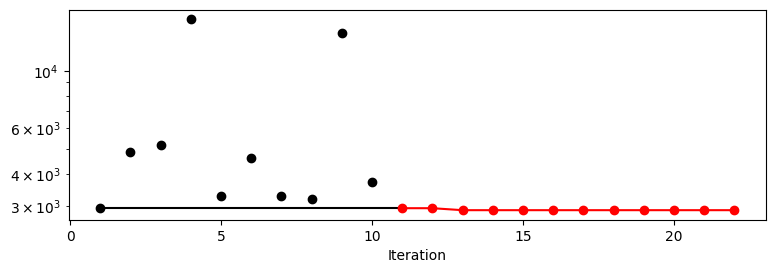

In [12]:
spot_tuner.plot_progress(log_y=True, filename=None)

### Tuned Hyperparameters and Their Importance

Results can be printed in tabular form.

In [13]:
from spotPython.utils.eda import gen_design_table
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name           | type   | default   |   lower |   upper | tuned               | transform             |   importance | stars   |
|----------------|--------|-----------|---------|---------|---------------------|-----------------------|--------------|---------|
| l1             | int    | 3         |     3.0 |     8.0 | 4.0                 | transform_power_2_int |        52.38 | **      |
| epochs         | int    | 4         |     4.0 |     9.0 | 6.0                 | transform_power_2_int |         0.00 |         |
| batch_size     | int    | 4         |     1.0 |     4.0 | 4.0                 | transform_power_2_int |         1.76 | *       |
| act_fn         | factor | ReLU      |     0.0 |     5.0 | Swish               | None                  |       100.00 | ***     |
| optimizer      | factor | SGD       |     0.0 |    11.0 | Adamax              | None                  |         0.06 |         |
| dropout_prob   | float  | 0.01      |     0.0 |    0.25 | 0.20459898975519586 | N

A histogram can be used to visualize the most important hyperparameters.

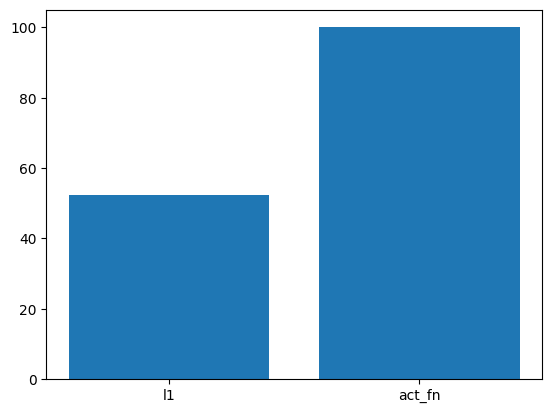

In [14]:
spot_tuner.plot_importance(threshold=10.0)

### Detailed Hyperparameter Plots

l1:  52.37789923892743
epochs:  0.001
batch_size:  1.756309046524265
act_fn:  100.0
optimizer:  0.060385950239671866
dropout_prob:  0.001
lr_mult:  0.006701328684566135
patience:  0.001
impo: [['l1', 52.37789923892743], ['epochs', 0.001], ['batch_size', 1.756309046524265], ['act_fn', 100.0], ['optimizer', 0.060385950239671866], ['dropout_prob', 0.001], ['lr_mult', 0.006701328684566135], ['patience', 0.001]]
indices: [3, 0, 2, 4, 6, 1, 5, 7]
indices after max_imp selection: [3, 0, 2]


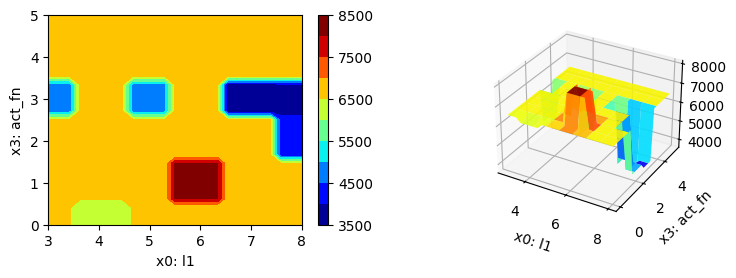

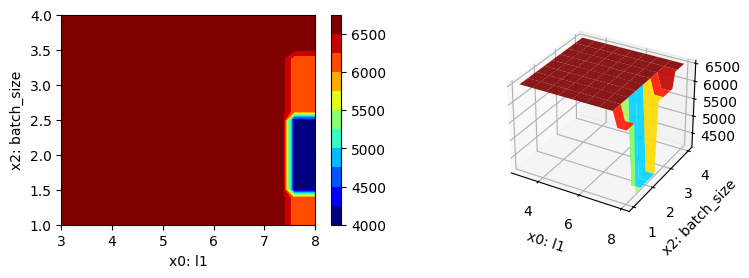

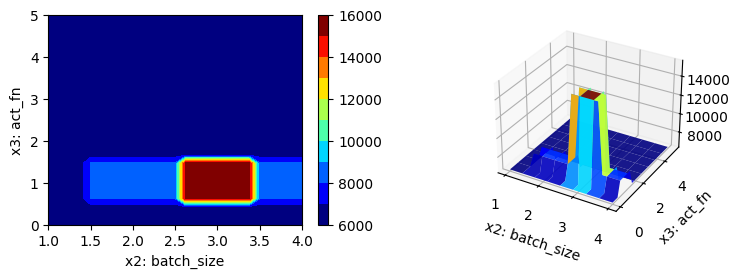

In [15]:
#| label: 024_plot_important_hyperparameter_contour
spot_tuner.plot_important_hyperparameter_contour(max_imp=3)

### Parallel Coordinates Plots

In [16]:
#| label: 024_parallel_plot
spot_tuner.parallel_plot()

## Load the saved experiment and get the hyperparameters (tuned architecture)

In [17]:
from spotPython.utils.file import get_experiment_from_PREFIX
config = get_experiment_from_PREFIX("100")["config"]
config

{'l1': 16,
 'epochs': 64,
 'batch_size': 16,
 'act_fn': Swish(),
 'optimizer': 'Adamax',
 'dropout_prob': 0.20459898975519586,
 'lr_mult': 9.086133494781139,
 'patience': 4,
 'initialization': 'Default'}

### Cross Validation With Lightning

* The `KFold` class from `sklearn.model_selection` is used to generate the folds for cross-validation.
* These mechanism is used to generate the folds for the final evaluation of the model.
* The `CrossValidationDataModule` class [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/data/lightcrossvalidationdatamodule.py) is used to generate the folds for the hyperparameter tuning process.
* It is called from the `cv_model` function [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/light/cvmodel.py).

In [18]:
from spotPython.light.cvmodel import cv_model
from spotPython.hyperparameters.values import set_control_key_value
set_control_key_value(control_dict=fun_control,
                        key="k_folds",
                        value=2,
                        replace=True)
set_control_key_value(control_dict=fun_control,
                        key="test_size",
                        value=0.6,
                        replace=True)
cv_model(config, fun_control)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 425    | [16, 10] | [16, 1]  
-------------------------------------------------------------
425       Trainable params
0         Non-trainable params
425       Total params
0.002     Total estimated model params size (MB)


k: 0
Train Dataset Size: 221
Val Dataset Size: 221


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     7318.41064453125      │
│         val_loss          │     7318.41064453125      │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 425    | [16, 10] | [16, 1]  
-------------------------------------------------------------
425       Trainable params
0         Non-trainable params
425       Total params
0.002     Total estimated model params size (MB)


train_model result: {'val_loss': 7318.41064453125, 'hp_metric': 7318.41064453125}
k: 1
Train Dataset Size: 221
Val Dataset Size: 221


`Trainer.fit` stopped: `max_epochs=64` reached.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │       19799.2109375       │
│         val_loss          │       19799.2109375       │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 19799.2109375, 'hp_metric': 19799.2109375}


13558.810791015625

## Test on the full data set

In [19]:
from spotPython.light.testmodel import test_model
test_model(config, fun_control)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 425    | [16, 10] | [16, 1]  
-------------------------------------------------------------
425       Trainable params
0         Non-trainable params
425       Total params
0.002     Total estimated model params size (MB)


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.16, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 71


Restoring states from the checkpoint path at /Users/bartz/workspace/Hyperparameter-Tuning-Cookbook/runs/saved_models/16_64_16_Swish_Adamax_0.2046_9.0861_4_Default_TEST/last.ckpt
Loaded model weights from the checkpoint at /Users/bartz/workspace/Hyperparameter-Tuning-Cookbook/runs/saved_models/16_64_16_Swish_Adamax_0.2046_9.0861_4_Default_TEST/last.ckpt


LightDataModule.setup(): stage: TrainerFn.TESTING
test_size: 0.6 used for test dataset.
LightDataModule.test_dataloader(). Test set size: 266


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      6185.9658203125      │
│         val_loss          │      6185.9658203125      │
└───────────────────────────┴───────────────────────────┘

test_model result: {'val_loss': 6185.9658203125, 'hp_metric': 6185.9658203125}


(6185.9658203125, 6185.9658203125)

## Load the last model

In [20]:
from spotPython.light.loadmodel import load_light_from_checkpoint
model_loaded = load_light_from_checkpoint(config, fun_control)

config: {'l1': 16, 'epochs': 64, 'batch_size': 16, 'act_fn': Swish(), 'optimizer': 'Adamax', 'dropout_prob': 0.20459898975519586, 'lr_mult': 9.086133494781139, 'patience': 4, 'initialization': 'Default'}
Loading model with 16_64_16_Swish_Adamax_0.2046_9.0861_4_Default_TEST from runs/saved_models/16_64_16_Swish_Adamax_0.2046_9.0861_4_Default_TEST/last.ckpt
Model: NetLightRegression(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=16, bias=True)
    (1): Swish()
    (2): Dropout(p=0.20459898975519586, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): Swish()
    (5): Dropout(p=0.20459898975519586, inplace=False)
    (6): Linear(in_features=8, out_features=8, bias=True)
    (7): Swish()
    (8): Dropout(p=0.20459898975519586, inplace=False)
    (9): Linear(in_features=8, out_features=4, bias=True)
    (10): Swish()
    (11): Dropout(p=0.20459898975519586, inplace=False)
    (12): Linear(in_features=4, out_features=1, bias=True)
  )
)


In [21]:
from spotPython.utils.init import get_feature_names
get_feature_names(fun_control)

['age',
 'sex',
 'bmi',
 'bp',
 's1_tc',
 's2_ldl',
 's3_hdl',
 's4_tch',
 's5_ltg',
 's6_glu']

### Integrated Gradients

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 425    | [16, 10] | [16, 1]  
-------------------------------------------------------------
425       Trainable params
0         Non-trainable params
425       Total params
0.002     Total estimated model params size (MB)


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.16, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 71
LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      5670.8681640625      │
│         val_loss          │      5670.8681640625      │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 5670.8681640625, 'hp_metric': 5670.8681640625}
config: {'l1': 16, 'epochs': 64, 'batch_size': 16, 'act_fn': Swish(), 'optimizer': 'Adamax', 'dropout_prob': 0.20459898975519586, 'lr_mult': 9.086133494781139, 'patience': 4, 'initialization': 'Default'}
Loading model with 16_64_16_Swish_Adamax_0.2046_9.0861_4_Default_TRAIN from runs/saved_models/16_64_16_Swish_Adamax_0.2046_9.0861_4_Default_TRAIN/last.ckpt
Model: NetLightRegression(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=16, bias=True)
    (1): Swish()
    (2): Dropout(p=0.20459898975519586, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): Swish()
    (5): Dropout(p=0.20459898975519586, inplace=False)
    (6): Linear(in_features=8, out_features=8, bias=True)
    (7): Swish()
    (8): Dropout(p=0.20459898975519586, inplace=False)
    (9): Linear(in_features=8, out_features=4, bias=True)
    (10): Swish()
    (11): Dropout(p=0.20459898975519586,

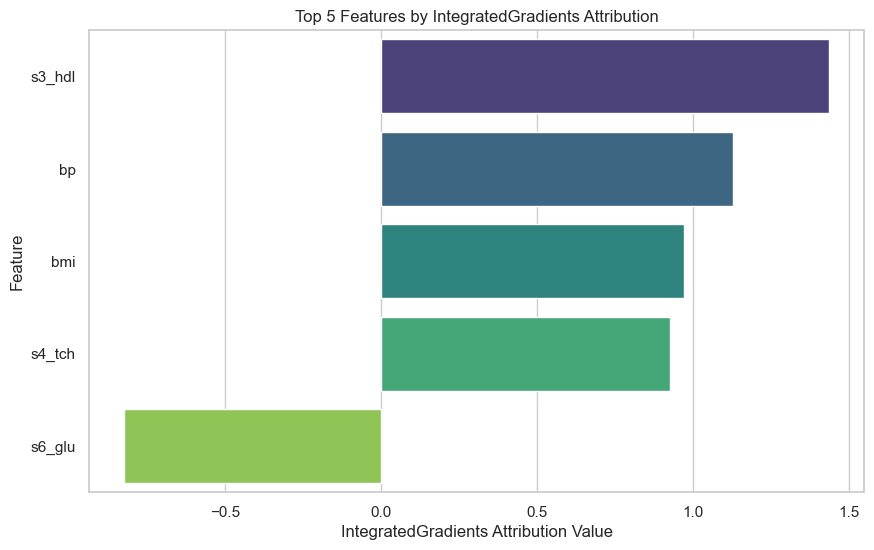

In [22]:
from spotPython.plot.xai import get_attributions, plot_attributions
df = get_attributions(spot_tuner, fun_control, attr_method="IntegratedGradients")
print(df)
plot_attributions(df)

### Deep Lift

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 425    | [16, 10] | [16, 1]  
-------------------------------------------------------------
425       Trainable params
0         Non-trainable params
425       Total params
0.002     Total estimated model params size (MB)


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.16, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 71
LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │        6056.46875         │
│         val_loss          │        6056.46875         │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 6056.46875, 'hp_metric': 6056.46875}
config: {'l1': 16, 'epochs': 64, 'batch_size': 16, 'act_fn': Swish(), 'optimizer': 'Adamax', 'dropout_prob': 0.20459898975519586, 'lr_mult': 9.086133494781139, 'patience': 4, 'initialization': 'Default'}
Loading model with 16_64_16_Swish_Adamax_0.2046_9.0861_4_Default_TRAIN from runs/saved_models/16_64_16_Swish_Adamax_0.2046_9.0861_4_Default_TRAIN/last.ckpt
Model: NetLightRegression(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=16, bias=True)
    (1): Swish()
    (2): Dropout(p=0.20459898975519586, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): Swish()
    (5): Dropout(p=0.20459898975519586, inplace=False)
    (6): Linear(in_features=8, out_features=8, bias=True)
    (7): Swish()
    (8): Dropout(p=0.20459898975519586, inplace=False)
    (9): Linear(in_features=8, out_features=4, bias=True)
    (10): Swish()
    (11): Dropout(p=0.20459898975519586, inplace=F

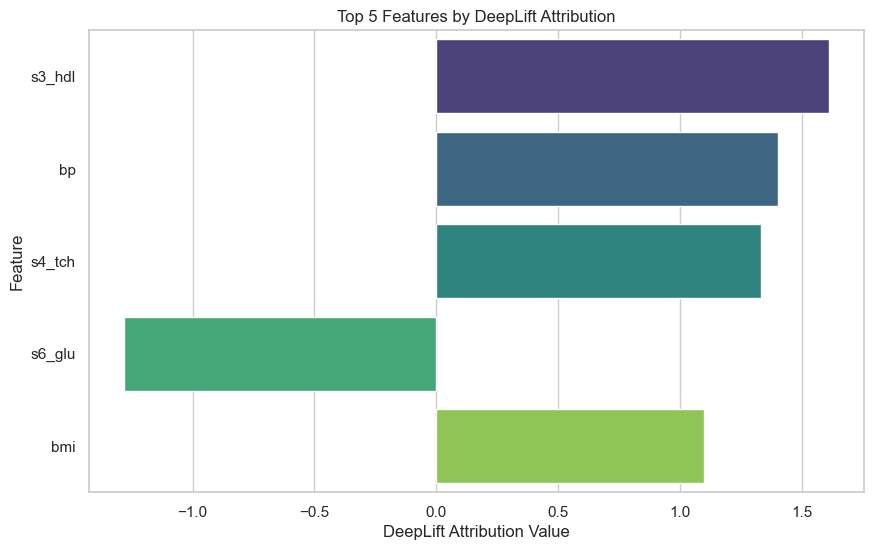

In [23]:
df = get_attributions(spot_tuner, fun_control, attr_method="DeepLift")
print(df)
plot_attributions(df,  attr_method="DeepLift")

### Feature Ablation

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 425    | [16, 10] | [16, 1]  
-------------------------------------------------------------
425       Trainable params
0         Non-trainable params
425       Total params
0.002     Total estimated model params size (MB)


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.16, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 71
LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     5355.05908203125      │
│         val_loss          │     5355.05908203125      │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 5355.05908203125, 'hp_metric': 5355.05908203125}
config: {'l1': 16, 'epochs': 64, 'batch_size': 16, 'act_fn': Swish(), 'optimizer': 'Adamax', 'dropout_prob': 0.20459898975519586, 'lr_mult': 9.086133494781139, 'patience': 4, 'initialization': 'Default'}
Loading model with 16_64_16_Swish_Adamax_0.2046_9.0861_4_Default_TRAIN from runs/saved_models/16_64_16_Swish_Adamax_0.2046_9.0861_4_Default_TRAIN/last.ckpt
Model: NetLightRegression(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=16, bias=True)
    (1): Swish()
    (2): Dropout(p=0.20459898975519586, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): Swish()
    (5): Dropout(p=0.20459898975519586, inplace=False)
    (6): Linear(in_features=8, out_features=8, bias=True)
    (7): Swish()
    (8): Dropout(p=0.20459898975519586, inplace=False)
    (9): Linear(in_features=8, out_features=4, bias=True)
    (10): Swish()
    (11): Dropout(p=0.2045989897551958

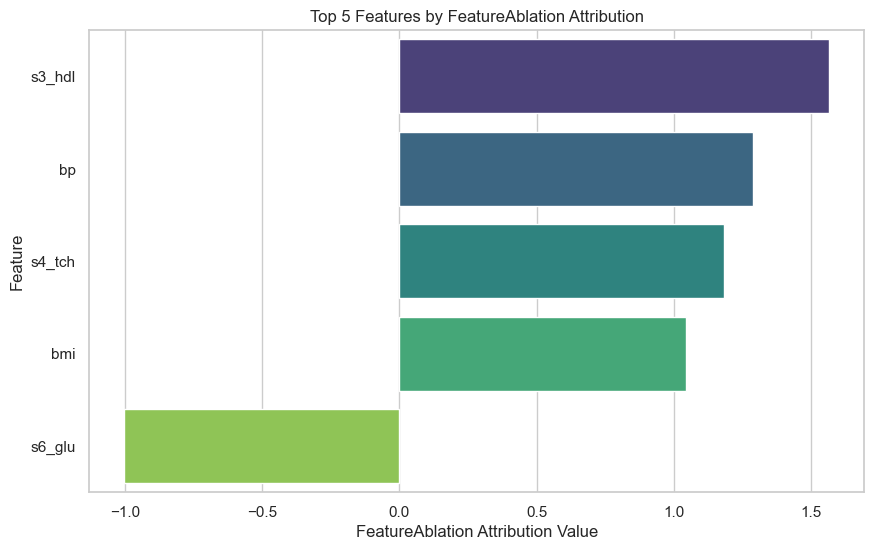

In [24]:
df = get_attributions(spot_tuner, fun_control, attr_method="FeatureAblation")
print(df)
plot_attributions(df, attr_method="FeatureAblation")

## Visualizing the Activations, Weights, and Gradients

In neural networks, activations, weights, and gradients are fundamental concepts that play different.

1. Activations:

   Activations refer to the outputs of neurons after applying an activation function. In neural networks, the input passes through each neuron of the network layers, where each unit calculates a weighted sum of its inputs and then applies a non-linear activation function (such as ReLU, Sigmoid, or Tanh). These activation functions help introduce non-linearity into the model, enabling the neural network to learn complex relationships between the input data and the predictions. In short, activations are the outputs that are forwarded by the neurons after applying the activation function.

2. Weights:

   Weights are parameters within a neural network that control the strength of the connection between two neurons in successive layers. They are adjusted during the training process to enable the neural network to perform the desired task as well as possible. Each input is multiplied by a weight, and the neural network learns by adjusting these weights based on the error between the predictions and the actual values. Adjusting the weights allows the network to recognize patterns and relationships in the input data and use them for predictions or classifications.

3. Gradients:

   In the context of machine learning and specifically in neural networks, gradients are a measure of the rate of change or the slope of the loss function (a function that measures how well the network performs in predicting the desired output) with respect to the weights. During the training process, the goal is to minimize the value of the loss function to improve the model’s performance. The gradients indicate the direction and size of the steps that need to be taken to adjust the weights in a way that minimizes the loss (known as gradient descent). By repeatedly adjusting the weights in the opposite direction of the gradient, the network can be effectively trained to improve its prediction accuracy.

::: {.callout-note}
### Reference:

* The following code is based on [[PyTorch Lightning TUTORIAL 2: ACTIVATION FUNCTIONS]](https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/02-activation-functions.html), Author: Phillip Lippe, License: [[CC BY-SA]](https://creativecommons.org/licenses/by-sa/3.0/), Generated: 2023-03-15T09:52:39.179933.

:::

After we have trained the models, we can look at the actual activation values that find inside the model. For instance, how many neurons are set to zero in ReLU? Where do we find most values in Tanh? To answer these questions, we can write a simple function which takes a trained model, applies it to a batch of images, and plots the histogram of the activations inside the network:


In [25]:
from spotPython.plot.xai import (get_activations, get_gradients, get_weights, plot_nn_values_hist, plot_nn_values_scatter, visualize_weights, visualize_gradients, visualize_activations, visualize_activations_distributions, visualize_gradient_distributions, visualize_weights_distributions)
import pprint

In [26]:
from spotPython.utils.file import get_experiment_from_PREFIX
get_experiment_from_PREFIX("100", return_dict=False)
pprint.pprint(config)
batch_size = config["batch_size"]
print(batch_size)

{'act_fn': Swish(),
 'batch_size': 16,
 'dropout_prob': 0.20459898975519586,
 'epochs': 64,
 'initialization': 'Default',
 'l1': 16,
 'lr_mult': 9.086133494781139,
 'optimizer': 'Adamax',
 'patience': 4}
16


In [27]:
from spotPython.light.loadmodel import load_light_from_checkpoint
model_loaded = load_light_from_checkpoint(config, fun_control)
model = model_loaded.to("cpu")

config: {'l1': 16, 'epochs': 64, 'batch_size': 16, 'act_fn': Swish(), 'optimizer': 'Adamax', 'dropout_prob': 0.20459898975519586, 'lr_mult': 9.086133494781139, 'patience': 4, 'initialization': 'Default'}
Loading model with 16_64_16_Swish_Adamax_0.2046_9.0861_4_Default_TEST from runs/saved_models/16_64_16_Swish_Adamax_0.2046_9.0861_4_Default_TEST/last.ckpt
Model: NetLightRegression(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=16, bias=True)
    (1): Swish()
    (2): Dropout(p=0.20459898975519586, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): Swish()
    (5): Dropout(p=0.20459898975519586, inplace=False)
    (6): Linear(in_features=8, out_features=8, bias=True)
    (7): Swish()
    (8): Dropout(p=0.20459898975519586, inplace=False)
    (9): Linear(in_features=8, out_features=4, bias=True)
    (10): Swish()
    (11): Dropout(p=0.20459898975519586, inplace=False)
    (12): Linear(in_features=4, out_features=1, bias=True)
  )
)


### Weights

In [28]:
weights, index = get_weights(model, return_index=True)
print(index)

[0, 3, 6, 9, 12]


160 values in Layer Layer 0.
9 padding values added.
169 values now in Layer Layer 0.


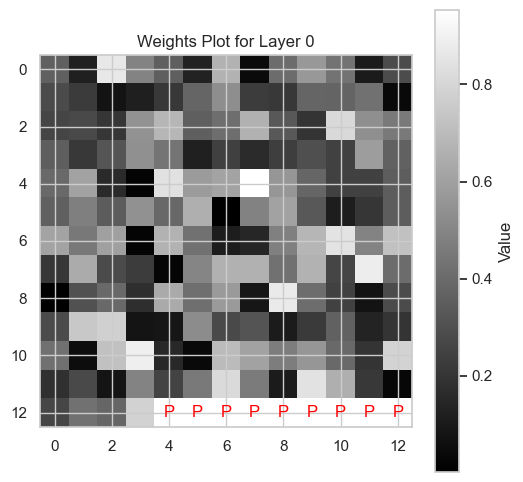

128 values in Layer Layer 3.
16 padding values added.
144 values now in Layer Layer 3.


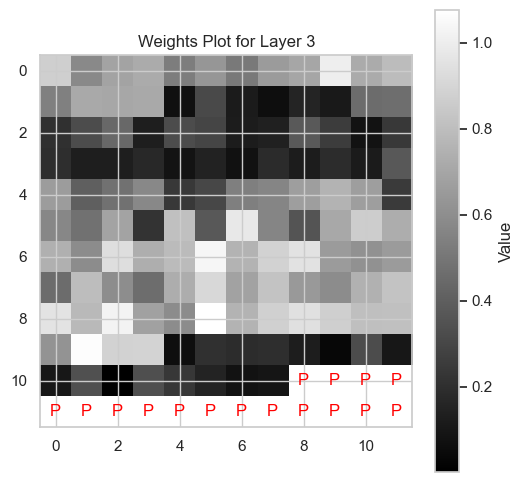

64 values in Layer Layer 6.
64 values now in Layer Layer 6.


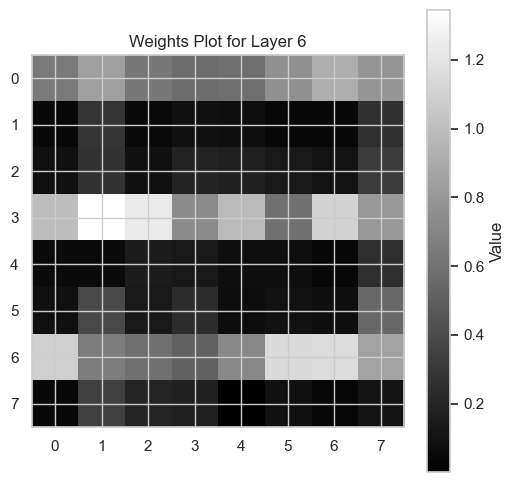

32 values in Layer Layer 9.
4 padding values added.
36 values now in Layer Layer 9.


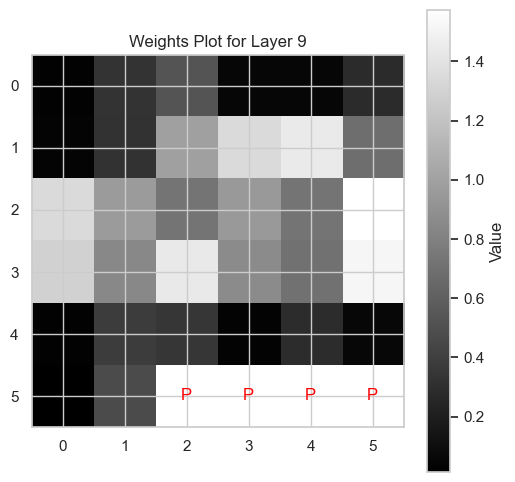

4 values in Layer Layer 12.
4 values now in Layer Layer 12.


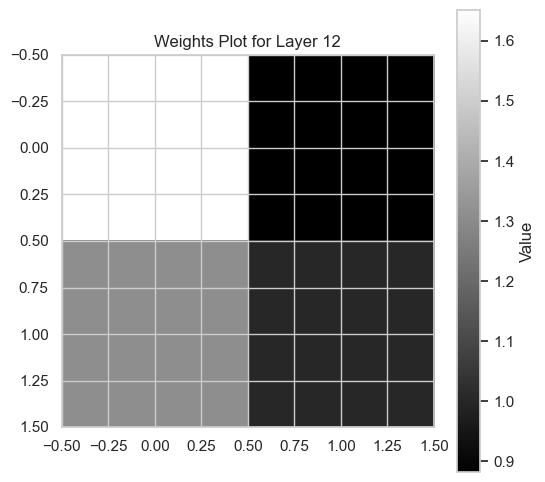

In [29]:
visualize_weights(model, absolute=True, cmap="gray", figsize=(6, 6))

n:5


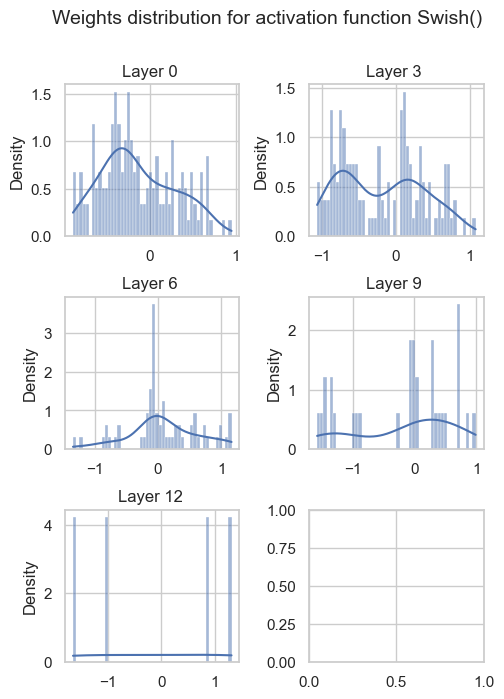

In [30]:
visualize_weights_distributions(model, color=f"C{0}")

### Activations

In [31]:
activations = get_activations(model, fun_control=fun_control, batch_size=batch_size, device = "cpu")

net: NetLightRegression(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=16, bias=True)
    (1): Swish()
    (2): Dropout(p=0.20459898975519586, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): Swish()
    (5): Dropout(p=0.20459898975519586, inplace=False)
    (6): Linear(in_features=8, out_features=8, bias=True)
    (7): Swish()
    (8): Dropout(p=0.20459898975519586, inplace=False)
    (9): Linear(in_features=8, out_features=4, bias=True)
    (10): Swish()
    (11): Dropout(p=0.20459898975519586, inplace=False)
    (12): Linear(in_features=4, out_features=1, bias=True)
  )
)


net: NetLightRegression(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=16, bias=True)
    (1): Swish()
    (2): Dropout(p=0.20459898975519586, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): Swish()
    (5): Dropout(p=0.20459898975519586, inplace=False)
    (6): Linear(in_features=8, out_features=8, bias=True)
    (7): Swish()
    (8): Dropout(p=0.20459898975519586, inplace=False)
    (9): Linear(in_features=8, out_features=4, bias=True)
    (10): Swish()
    (11): Dropout(p=0.20459898975519586, inplace=False)
    (12): Linear(in_features=4, out_features=1, bias=True)
  )
)
256 values in Layer 0.
256 values now in Layer 0.


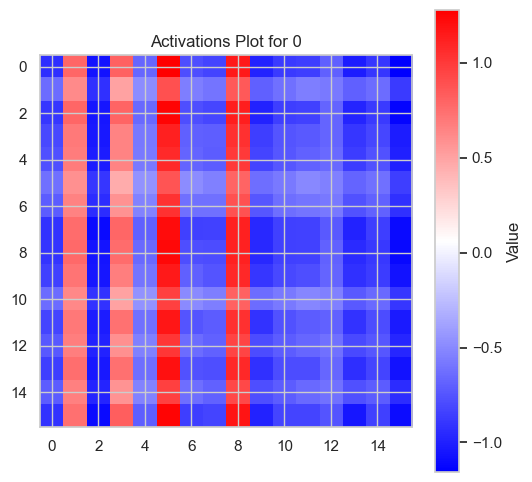

128 values in Layer 3.
16 padding values added.
144 values now in Layer 3.


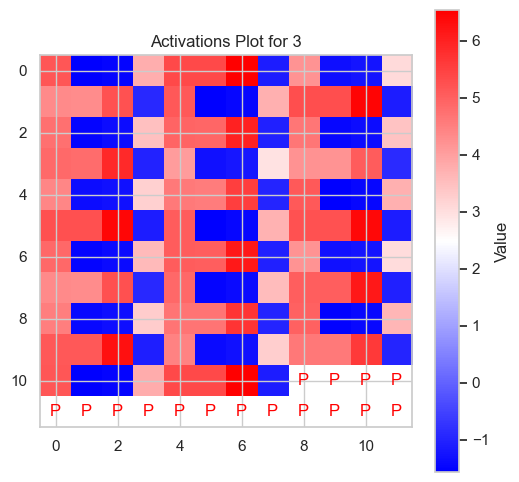

128 values in Layer 6.
16 padding values added.
144 values now in Layer 6.


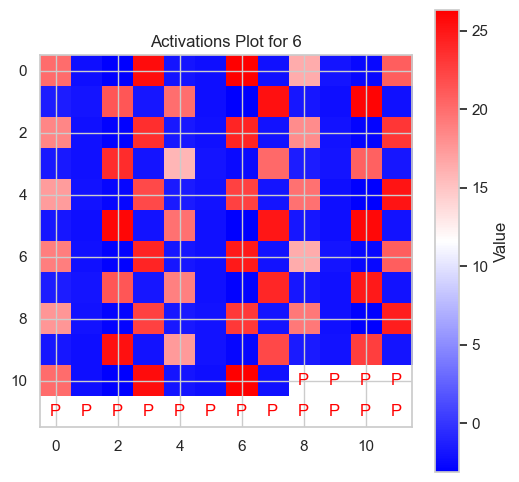

64 values in Layer 9.
64 values now in Layer 9.


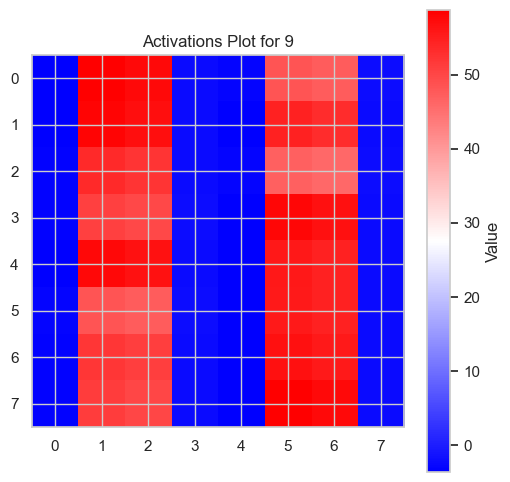

16 values in Layer 12.
16 values now in Layer 12.


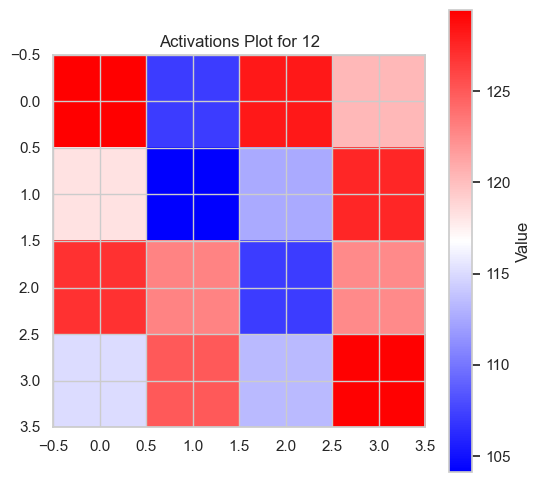

In [32]:
visualize_activations(model, fun_control=fun_control, batch_size=batch_size, device = "cpu", cmap="BlueWhiteRed", absolute=False)

* Absolute values of the activations are plotted:

net: NetLightRegression(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=16, bias=True)
    (1): Swish()
    (2): Dropout(p=0.20459898975519586, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): Swish()
    (5): Dropout(p=0.20459898975519586, inplace=False)
    (6): Linear(in_features=8, out_features=8, bias=True)
    (7): Swish()
    (8): Dropout(p=0.20459898975519586, inplace=False)
    (9): Linear(in_features=8, out_features=4, bias=True)
    (10): Swish()
    (11): Dropout(p=0.20459898975519586, inplace=False)
    (12): Linear(in_features=4, out_features=1, bias=True)
  )
)
256 values in Layer 0.
256 values now in Layer 0.


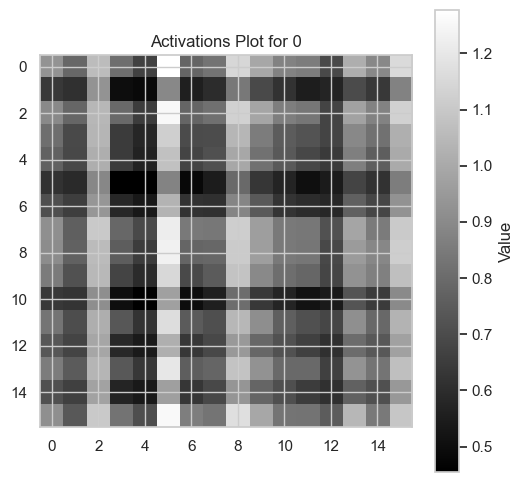

128 values in Layer 3.
16 padding values added.
144 values now in Layer 3.


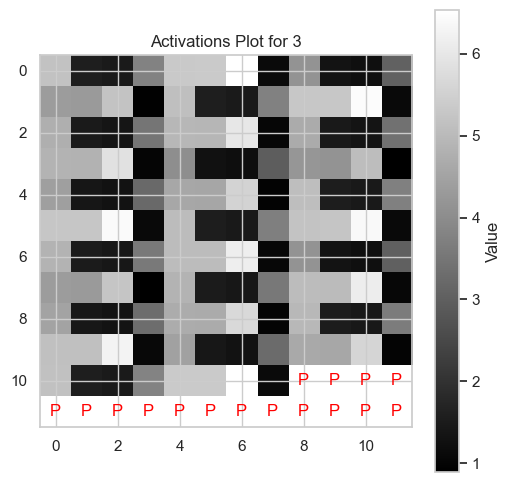

128 values in Layer 6.
16 padding values added.
144 values now in Layer 6.


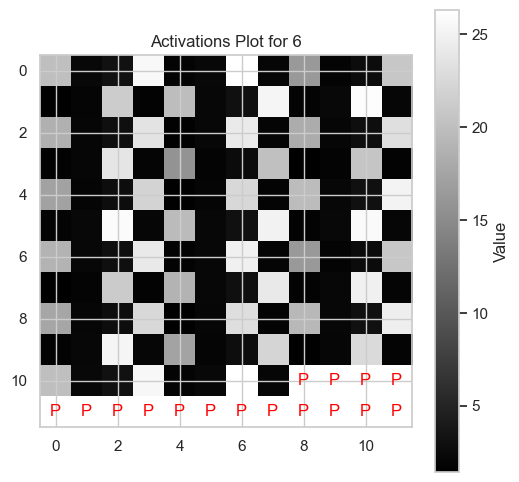

64 values in Layer 9.
64 values now in Layer 9.


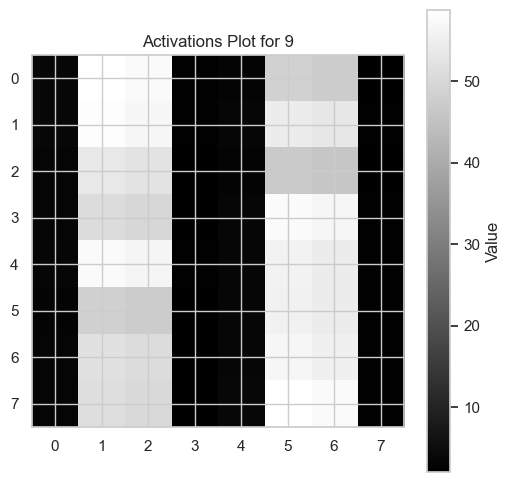

16 values in Layer 12.
16 values now in Layer 12.


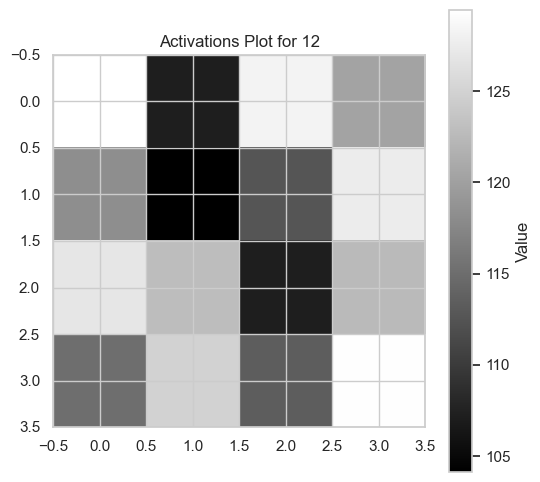

In [33]:
visualize_activations(model, fun_control=fun_control, batch_size=batch_size, device = "cpu", absolute=True)

net: NetLightRegression(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=16, bias=True)
    (1): Swish()
    (2): Dropout(p=0.20459898975519586, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): Swish()
    (5): Dropout(p=0.20459898975519586, inplace=False)
    (6): Linear(in_features=8, out_features=8, bias=True)
    (7): Swish()
    (8): Dropout(p=0.20459898975519586, inplace=False)
    (9): Linear(in_features=8, out_features=4, bias=True)
    (10): Swish()
    (11): Dropout(p=0.20459898975519586, inplace=False)
    (12): Linear(in_features=4, out_features=1, bias=True)
  )
)
n:5


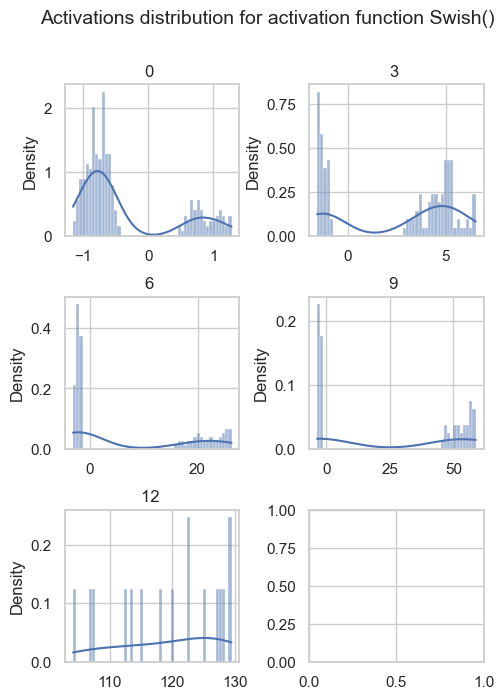

In [34]:
visualize_activations_distributions(net=model, fun_control=fun_control, batch_size=batch_size, device="cpu", color="C0", columns=2)

### Gradients

In [35]:
gradients = get_gradients(model, fun_control, batch_size, device="cpu")

160 values in Layer layers.0.weight.
9 padding values added.
169 values now in Layer layers.0.weight.


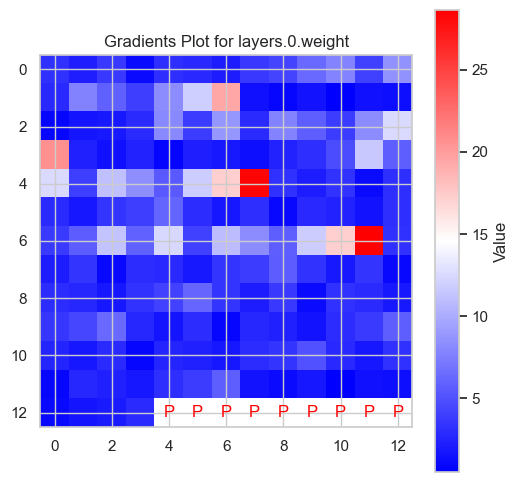

128 values in Layer layers.3.weight.
16 padding values added.
144 values now in Layer layers.3.weight.


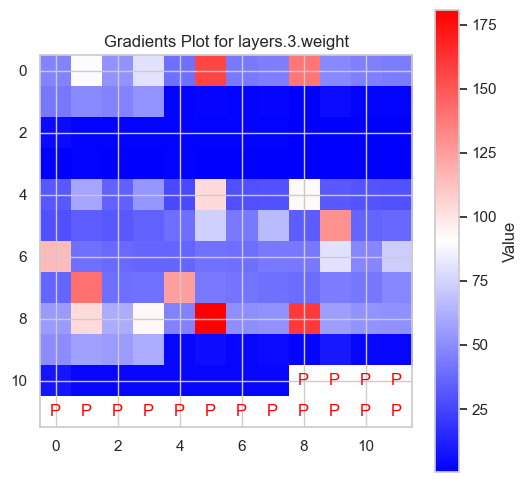

64 values in Layer layers.6.weight.
64 values now in Layer layers.6.weight.


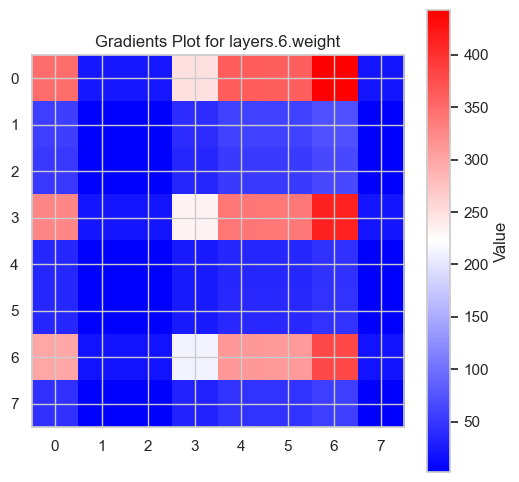

32 values in Layer layers.9.weight.
4 padding values added.
36 values now in Layer layers.9.weight.


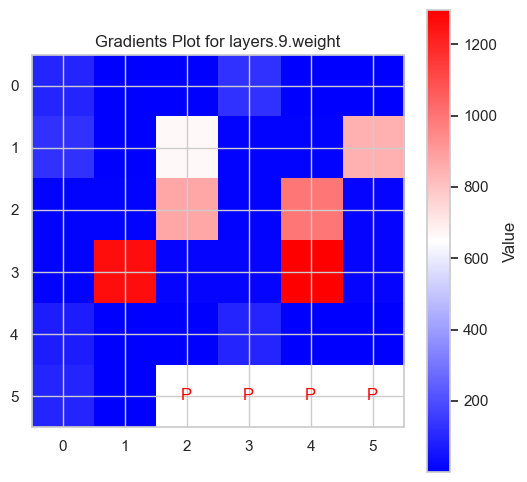

4 values in Layer layers.12.weight.
4 values now in Layer layers.12.weight.


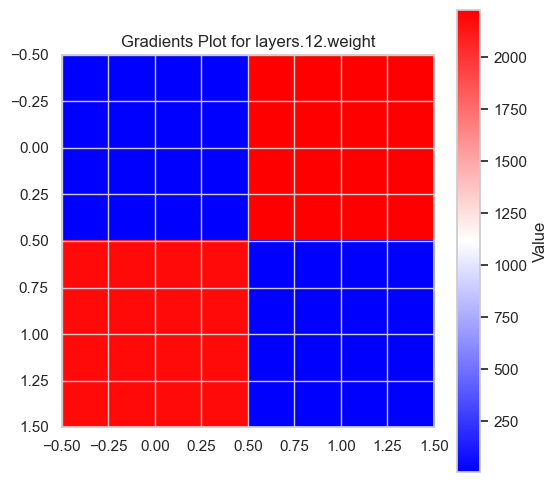

In [36]:
visualize_gradients(model, fun_control, batch_size, absolute=True, cmap="BlueWhiteRed", figsize=(6, 6))

n:5


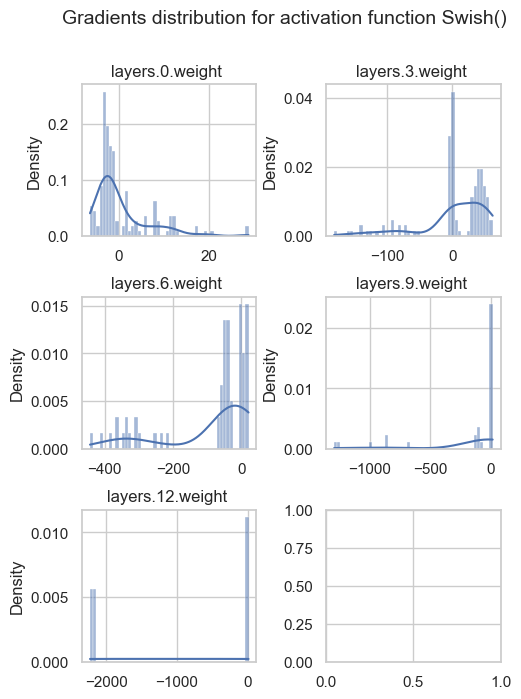

In [37]:
visualize_gradient_distributions(model, fun_control, batch_size=batch_size, color=f"C{0}")

## Layer Conductance

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 425    | [16, 10] | [16, 1]  
-------------------------------------------------------------
425       Trainable params
0         Non-trainable params
425       Total params
0.002     Total estimated model params size (MB)


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.16, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 71
LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     7280.12744140625      │
│         val_loss          │     7280.12744140625      │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 425    | [16, 10] | [16, 1]  
-------------------------------------------------------------
425       Trainable params
0         Non-trainable params
425       Total params
0.002     Total estimated model params size (MB)


train_model result: {'val_loss': 7280.12744140625, 'hp_metric': 7280.12744140625}
config: {'l1': 16, 'epochs': 64, 'batch_size': 16, 'act_fn': Swish(), 'optimizer': 'Adamax', 'dropout_prob': 0.20459898975519586, 'lr_mult': 9.086133494781139, 'patience': 4, 'initialization': 'Default'}
Loading model with 16_64_16_Swish_Adamax_0.2046_9.0861_4_Default_TRAIN from runs/saved_models/16_64_16_Swish_Adamax_0.2046_9.0861_4_Default_TRAIN/last.ckpt
Model: NetLightRegression(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=16, bias=True)
    (1): Swish()
    (2): Dropout(p=0.20459898975519586, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): Swish()
    (5): Dropout(p=0.20459898975519586, inplace=False)
    (6): Linear(in_features=8, out_features=8, bias=True)
    (7): Swish()
    (8): Dropout(p=0.20459898975519586, inplace=False)
    (9): Linear(in_features=8, out_features=4, bias=True)
    (10): Swish()
    (11): Dropout(p=0.2045989897551958

`Trainer.fit` stopped: `max_epochs=64` reached.


LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      27909.080078125      │
│         val_loss          │      27909.080078125      │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 27909.080078125, 'hp_metric': 27909.080078125}
config: {'l1': 16, 'epochs': 64, 'batch_size': 16, 'act_fn': Swish(), 'optimizer': 'Adamax', 'dropout_prob': 0.20459898975519586, 'lr_mult': 9.086133494781139, 'patience': 4, 'initialization': 'Default'}
Loading model with 16_64_16_Swish_Adamax_0.2046_9.0861_4_Default_TRAIN from runs/saved_models/16_64_16_Swish_Adamax_0.2046_9.0861_4_Default_TRAIN/last.ckpt
Model: NetLightRegression(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=16, bias=True)
    (1): Swish()
    (2): Dropout(p=0.20459898975519586, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): Swish()
    (5): Dropout(p=0.20459898975519586, inplace=False)
    (6): Linear(in_features=8, out_features=8, bias=True)
    (7): Swish()
    (8): Dropout(p=0.20459898975519586, inplace=False)
    (9): Linear(in_features=8, out_features=4, bias=True)
    (10): Swish()
    (11): Dropout(p=0.20459898975519586,

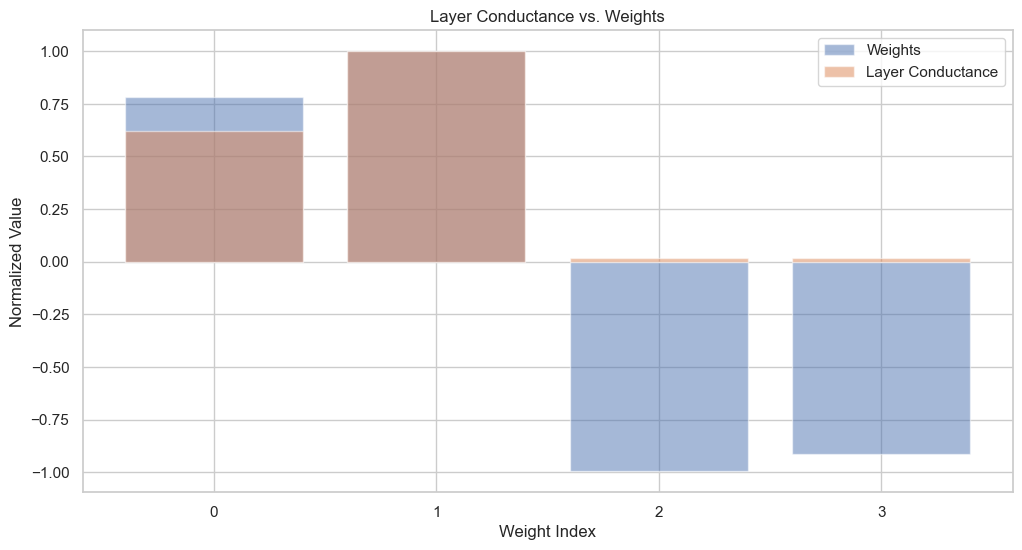

In [38]:
from spotPython.plot.xai import get_weights_conductance_last_layer, plot_conductance_last_layer
w, c = get_weights_conductance_last_layer(spot_tuner, fun_control)
plot_conductance_last_layer(w,c)